In [6]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [7]:
import json

## Load Data from CSV

In [8]:
# load TPM data
tpm_data_file = 'data/TPM_counts.tsv'
sample2condition_file = 'data/new_sample2condition.txt'
diagnostic_genes_file = 'data/diagnostic_genes.csv'
unstable_diag_genes_file = 'data/unstable_diagnostic_expression.csv'

# load TPM data
df = pd.read_csv(tpm_data_file,sep='\t').fillna('')

    
# load mapping from sample to condition
with open(sample2condition_file,'r') as f:
#     sample2condition = dict(x.strip().split() for x in f.readlines())
    sample2condition = json.load(f)
    
# load data for diagnostic genes:
df_diagnostics = pd.read_csv(diagnostic_genes_file)
df_diagnostics['Gene'] = df_diagnostics['Gene'].apply(lambda x: "EQU24_RS20550" if x == "MBURv2_160514" else x)
df_diagnostics


# Mission: Reorganize dataset into 98x4213 dataframe where
#     --> columns represent each locus
#     --> rows represent each sample present

df_raw_tpm = df.iloc[:, 10:].T
loci = df["locus_tag"]
df_raw_tpm = df_raw_tpm.set_axis(loci, axis = 1)

df_raw_tpm 

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1C-5G-N-BR2_tpm,33.432274,48.142385,22.006566,64.648318,39.358066,34.654512,107.541275,33.869275,23.770815,20.064562,...,9003.930101,20.600870,37.114422,39.499880,42.467068,30.766617,166.101675,59.523445,259.828426,404.714461
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [9]:
# Clean Data: 

# Remove FM 80 Fermentor Run from NO3_LowO2_Slow_Growth
# 5GB1_FM80_t2_TR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_FM80_t2_TR1_tpm")
# 5GB1_FM80_t4_TR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_FM80_t4_TR1_tpm")

# Remove the w/ Lanthanum samples that are not Joseph's

# 5GB1_vial_wLa_TR3_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_vial_wLa_TR3_tpm")
# 5GB1C-5G-La-BR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-La-BR1_tpm")
# 5GB1C-5G-La-BR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-La-BR2_tpm")

# Remove the w/o Lanthanum samples that are not Joseph's

# 5GB1_vial_woLa_TR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1_vial_woLa_TR2_tpm")
# 5GB1C-5G-N-BR1_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-N-BR1_tpm")
# 5GB1C-5G-N-BR2_tpm
df_raw_tpm = df_raw_tpm.drop("5GB1C-5G-N-BR2_tpm")

# Re-Label the FM11 from LowO2_fast_growth as LowO2_low_iron_fast_growth
sample2condition['5GB1_FM11_TR1_QC_tpm'] = 'lowO2_low_iron_fast_growth'
sample2condition['5GB1_FM11_TR2_QC_tpm'] = 'lowO2_low_iron_fast_growth'

with open('data/new_sample2condition.txt', 'w') as file:
    file.write(json.dumps(sample2condition)) # use `json.loads` to do the reverse

df_raw_tpm

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
5GB1_ferm_Ack_QC_tpm,2.933003,1.607784,1.415515,3.200081,1.522728,2.013385,8.890269,1.632474,0.790911,0.446398,...,170.826337,0.973237,2.344352,2.331287,4.867523,2.300157,5.261582,9.389775,21.657488,27.832080
5GB1_ferm_WT_QC_tpm,6.033848,3.895284,2.549771,4.301580,3.797084,1.694449,9.506517,3.340407,2.160868,1.134421,...,259.349616,2.866741,1.856930,0.951269,3.972334,3.217944,12.526353,21.072962,42.254357,41.530602
5GB1_FM03_TR1_QC_tpm,48.864921,51.315629,33.906257,64.584281,74.801354,13.090237,50.320911,20.811187,21.910217,18.096708,...,6655.778183,56.948463,52.002311,60.628466,23.015801,104.488835,379.686212,500.129230,1191.565348,796.964423
5GB1_FM03_TR2_QC_tpm,52.197450,54.947425,29.979783,72.717824,62.709260,24.874673,71.255094,19.773190,19.421485,16.776993,...,6480.237054,50.243190,41.376658,66.581832,54.669612,103.864151,401.742811,495.262554,1232.784967,724.291958
5GB1_FM11_TR1_QC_tpm,25.751902,37.216017,21.716802,53.032824,46.348014,42.426259,58.772307,9.667881,8.212313,12.634273,...,6651.883413,25.635202,29.059082,59.545627,34.189659,78.264069,208.094267,260.011454,666.589153,461.697526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5GB1_pA9_yellow_tpm,38.810668,52.461746,34.914128,80.850761,49.349547,38.829856,65.199396,28.421940,34.998158,37.011081,...,8978.523141,38.296718,48.623546,64.643789,40.333764,92.044879,403.009110,329.903989,679.393946,723.410948
5GB1C-JG15-La-BR1_tpm,39.880174,45.465136,22.658157,69.119079,38.992158,67.033753,130.729298,39.968258,22.454067,18.039069,...,3318.767885,10.724405,39.422680,49.109710,46.810258,22.101468,96.169044,47.641158,134.795621,265.487592
5GB1C-JG15-La-BR2_tpm,38.355431,46.498139,22.753325,65.643179,35.870964,51.959561,120.575354,37.092594,20.769383,17.655632,...,3458.558649,15.496249,41.910716,53.086286,44.827579,19.753259,93.527806,60.667488,160.260255,308.428817
5GB1C-JG15-N-BR1_tpm,30.247582,37.152951,19.407103,57.590223,41.462392,44.527488,105.320613,27.798238,18.873435,15.578396,...,3997.726513,17.356475,41.685308,44.836637,47.307203,20.027390,89.780995,55.739018,174.197473,286.670085


In [10]:
df_raw_tpm = df_raw_tpm.T
df_raw_tpm

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_FM_85_TR1_tpm,5GB1_FM_85_TR2_tpm,5GB1_FM_86_TR1_tpm,5GB1_FM_87_TR1_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,2.933003,6.033848,48.864921,52.197450,25.751902,34.928170,28.322788,28.461759,28.479425,29.472757,...,24.749983,28.949182,45.819368,24.157536,38.557373,38.810668,39.880174,38.355431,30.247582,41.248441
EQU24_RS00010,1.607784,3.895284,51.315629,54.947425,37.216017,40.094206,27.387700,28.648564,26.498988,26.821965,...,47.174797,43.803272,31.653933,44.890393,52.552767,52.461746,45.465136,46.498139,37.152951,52.902410
EQU24_RS00015,1.415515,2.549771,33.906257,29.979783,21.716802,27.871558,16.570863,15.562811,16.589291,16.958650,...,9.149880,14.774317,20.236628,10.755231,31.350991,34.914128,22.658157,22.753325,19.407103,29.834124
EQU24_RS00020,3.200081,4.301580,64.584281,72.717824,53.032824,55.595529,36.795081,36.401903,37.513079,35.833478,...,58.475599,53.217719,36.787108,72.922943,74.848501,80.850761,69.119079,65.643179,57.590223,68.306759
EQU24_RS00025,1.522728,3.797084,74.801354,62.709260,46.348014,57.992363,27.432559,30.380176,26.852591,26.467246,...,29.858596,36.336110,36.231087,34.562485,50.324948,49.349547,38.992158,35.870964,41.462392,40.227192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,2.300157,3.217944,104.488835,103.864151,78.264069,59.685923,58.833576,57.223346,66.382013,69.196352,...,25.862525,34.268735,49.532913,22.858882,70.918047,92.044879,22.101468,19.753259,20.027390,24.508375
EQU24_RS22140,5.261582,12.526353,379.686212,401.742811,208.094267,210.820167,204.760175,204.759505,211.282600,218.557992,...,182.004412,181.576715,156.143274,188.453252,328.789579,403.009110,96.169044,93.527806,89.780995,130.851229
EQU24_RS22145,9.389775,21.072962,500.129230,495.262554,260.011454,331.355028,300.766500,309.148602,312.637538,317.603906,...,125.035490,182.821145,183.868377,179.069605,301.203428,329.903989,47.641158,60.667488,55.739018,66.415222


In [11]:
samples = list(sample2condition.keys())
# transpose dataframe to make experiments the rows and genes the columns
df_T = df.set_index('locus_tag')[samples].T.reset_index().rename(columns={'index':'sample'})

# your code here (add exp_condition column)
df_T['exp_condition'] = df_T['sample'].apply(lambda x: sample2condition.get(x))
df_T

df_Avg = df_T.groupby(['exp_condition']).mean()
df_Avg


locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
exp_condition,,,,,,,,,,,,,,,,,,,,,
LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,25.929209,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,9.568570,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,13.952268,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,27.046153,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,17.138966,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,22.640284,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,17.304281,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,18.955507,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,35.008462,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496


In [12]:
# Preprocessing before clustering

scalar = StandardScaler()
scaled_tpm_data = scalar.fit_transform(df_raw_tpm)
df_scaled_tpm = pd.DataFrame(data=scaled_tpm_data, index=df_raw_tpm.index,
                             columns=df_raw_tpm.columns)
df_scaled_tpm

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_FM_85_TR1_tpm,5GB1_FM_85_TR2_tpm,5GB1_FM_86_TR1_tpm,5GB1_FM_87_TR1_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.022822,-0.024095,-0.053279,-0.053205,-0.043901,-0.051028,-0.044245,-0.044109,-0.045185,-0.045064,...,-0.065286,-0.063787,-0.044614,-0.064622,-0.056429,-0.053114,-0.062250,-0.061300,-0.062224,-0.078089
EQU24_RS00010,-0.022951,-0.024318,-0.052586,-0.052414,-0.041522,-0.049726,-0.044443,-0.044069,-0.045613,-0.045639,...,-0.058400,-0.059241,-0.047914,-0.058337,-0.052457,-0.049462,-0.060489,-0.058792,-0.060150,-0.073448
EQU24_RS00015,-0.022969,-0.024458,-0.057507,-0.059589,-0.044738,-0.052807,-0.046733,-0.046832,-0.047757,-0.047777,...,-0.070077,-0.068126,-0.050573,-0.068684,-0.058475,-0.054157,-0.067678,-0.066106,-0.065481,-0.082634
EQU24_RS00020,-0.022796,-0.024276,-0.048836,-0.047308,-0.038241,-0.045818,-0.042452,-0.042432,-0.043231,-0.043685,...,-0.054930,-0.056360,-0.046718,-0.049841,-0.046128,-0.041868,-0.053033,-0.052894,-0.054010,-0.067315
EQU24_RS00025,-0.022959,-0.024328,-0.045948,-0.050184,-0.039628,-0.045214,-0.044434,-0.043703,-0.045537,-0.045716,...,-0.063718,-0.061527,-0.046848,-0.061468,-0.053089,-0.050295,-0.062530,-0.062065,-0.058855,-0.078495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.022883,-0.024388,-0.037557,-0.038359,-0.033006,-0.044787,-0.037787,-0.038036,-0.036986,-0.036453,...,-0.064945,-0.062159,-0.043749,-0.065015,-0.047244,-0.038873,-0.067854,-0.067030,-0.065295,-0.084754
EQU24_RS22140,-0.022595,-0.023419,0.040229,0.047233,-0.006072,-0.006690,-0.006900,-0.006884,-0.005641,-0.004076,...,-0.016998,-0.017073,-0.018917,-0.014824,0.025952,0.044313,-0.044506,-0.044305,-0.044338,-0.042410
EQU24_RS22145,-0.022193,-0.022529,0.074272,0.074105,0.004699,0.023694,0.013421,0.015158,0.016284,0.017395,...,-0.034492,-0.016693,-0.012460,-0.017668,0.018121,0.024756,-0.059803,-0.054427,-0.054566,-0.068068


In [139]:
df_Avg

locus_tag,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,EQU24_RS00050,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
exp_condition,,,,,,,,,,,,,,,,,,,,,
LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,25.929209,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,9.568570,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,13.952268,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,27.046153,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,17.138966,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,22.640284,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,17.304281,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,18.955507,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,35.008462,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496


In [13]:
# Preprocessing before clustering
scalar = StandardScaler()

scaled_tpm_data = scalar.fit_transform(df_Avg)
df_avg_scaled_tpm = pd.DataFrame(data=scaled_tpm_data, index=df_Avg.index,
                             columns=df_Avg.columns).T
df_avg_scaled_tpm 

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.909002,-1.113499,-0.339628,0.752159,-0.215905,-0.077910,-0.036742,-0.800440,0.250164,1.064007,2.566352,-0.448025,0.630081,0.083214,-0.490574,-1.831540,0.802957,0.046266,1.435479,-1.367412
EQU24_RS00010,0.375879,-1.578377,-0.264732,0.583348,-0.262975,-0.550101,-0.363730,-0.166914,0.205724,1.617663,2.673926,-0.802287,0.667229,-0.243435,-0.529768,-1.370163,0.869095,0.017351,0.602563,-1.480295
EQU24_RS00015,-1.277528,-0.537212,-0.214131,0.557094,-0.011092,-0.865899,-0.292966,-1.259905,1.100505,1.144154,2.406532,-0.533059,0.619531,0.508193,0.170814,-1.469626,0.685363,-0.692150,1.189759,-1.228376
EQU24_RS00020,1.214163,-2.289077,0.340324,0.014674,0.043282,-0.102053,0.033310,-0.042794,1.272088,1.001425,1.340101,-0.813271,0.298830,-0.517893,-0.134374,-1.953208,0.527100,0.513216,0.865298,-1.611141
EQU24_RS00025,0.177218,-1.840263,0.021877,0.636042,0.073254,-0.450969,-0.537466,-0.624154,0.636633,0.547380,2.745112,-0.734405,0.720953,-0.879293,0.812341,-1.757539,0.552483,0.249991,0.546316,-0.895512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.224448,-0.941750,-0.674489,0.576261,-1.223329,-0.631435,-1.252614,-0.885554,1.245795,1.586486,0.024662,0.371401,0.634446,0.887685,0.727363,-1.476565,1.375760,-0.882123,1.597450,-0.835001
EQU24_RS22140,1.186216,-1.284894,-0.475628,0.231579,-1.131657,-0.539019,-1.242391,-0.449047,1.296014,1.078694,-0.085112,-0.021489,0.610629,1.230015,-0.186811,-1.506645,1.050734,-0.585724,1.915108,-1.090569
EQU24_RS22145,-0.684908,-0.648104,-0.625461,0.342034,-1.483142,-0.471344,-1.431407,-0.715348,0.716616,1.345035,0.083810,0.552406,0.700475,1.399826,0.540569,-1.335084,1.262869,-0.438083,1.907212,-1.017969


## FUNCTIONS

### Set Up

In [14]:
# variable-length argument list: keeps track of constant kmeans properties

kwargs_for_kmeans = {
            "init" : "k-means++",  
            "n_init" : 4, 
            "max_iter" : 400, 
            "random_state" : 42}
kwargs_for_kmeans

{'init': 'k-means++', 'n_init': 4, 'max_iter': 400, 'random_state': 42}

In [15]:
# Matplotlib Settings
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

### Cluster Scoring/Evaluation Methods

In [16]:
# Graph Scores

def plot_scores(scores, x_min, x_max, x_label, y_label, title):
    
    plt.rc('font', **font)
    
    # Plot the elbow
    elbow_plot = sns.lineplot(x=range(x_min, x_max), y=scores,
                              marker="o", size=3, legend=False)
    
    elbow_plot.set_xlabel(x_label, fontsize = 15)
    elbow_plot.set_ylabel(y_label, fontsize = 15)
    elbow_plot.set_title(title, fontsize = 17)
    

In [17]:
# Elbow Method

# Sum of squared error --> evaluate the qualuty of the clusters
def elbow_method(df_scaled_tpm, x_min = 5, x_max = 30):
    sum_squared_error = []

    for k_cluster_num in range(x_min, x_max):
        kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
        kmeans.fit(df_scaled_tpm)
        sum_squared_error.append(kmeans.inertia_)
    
    return sum_squared_error

In [18]:
# silhouette coefficients: 

def silhouette_method(df_scaled_tpm, x_min = 2 , x_max = 30 ):
    s_coefficients = []

    for k_cluster_num in range(x_min, x_max):
        kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
        kmeans.fit(df_scaled_tpm)
        score = silhouette_score(df_scaled_tpm, kmeans.labels_)
        s_coefficients.append(score)
    return s_coefficients

In [19]:
from sklearn.metrics import calinski_harabasz_score

def ch_method(df_scaled_tpm, x_min = 2 , x_max = 30):
    # Calinski Harabasz Scores: 
    ch_scores = []

    for k_cluster_num in range(x_min, x_max):
        kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
        kmeans.fit(df_scaled_tpm)
        score = calinski_harabasz_score(df_scaled_tpm, kmeans.labels_)
        ch_scores.append(score)
        
    return ch_scores

In [20]:
from sklearn.metrics import davies_bouldin_score

def db_method(df_scaled_tpm, x_min = 2, x_max = 30):

    # Davies-Bouldin Scores: 
    db_scores = []


    for k_cluster_num in range(x_min, x_max):
        kmeans = KMeans(n_clusters=k_cluster_num, **kwargs_for_kmeans)
        kmeans.fit(df_scaled_tpm)
        score = davies_bouldin_score(df_scaled_tpm, kmeans.labels_)
        db_scores.append(score)
        
    return db_scores

### Cluster Graphing

In [21]:
def plot_pca_var(pca, 
                 title="Variance explained by PCA components", tag = None):
    
    # title tag
    if tag:
        title = title + " (%s)"%tag
        
    # plot cumulative variance across components
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(title)
    plt.show()
    
    # plot individual explained variances for each component
    plt.bar(range(len(pca.explained_variance_ratio_)), 
            pca.explained_variance_ratio_,
            label="individual explained variance")
    
    plt.step(range(len(pca.explained_variance_ratio_)), 
             np.cumsum(pca.explained_variance_ratio_),
             label="cumulative explained variance",
             c='red')
    
    plt.xlabel('Number of Components')
    plt.ylabel("Explained Variance")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()
    

In [22]:
def clusterCompositionPlot(clusterNums, dataPointNum, title_add):
    plt.bar(clusterNums, dataPointNum)
    title = "Composition of Clusters of " + title_add
    plt.title(title, fontsize = 17)
    plt.xlabel("Cluster Number", fontsize = 15)
    plt.ylabel("Number of Datapoints", fontsize = 15)

In [53]:
def plot_kmeans(n_clusters, data, xlim, ylim, figsize = (12, 12)): 
    # Plotting our clusters!
    n_clusters= n_clusters
    kmeans = KMeans(n_clusters= n_clusters, **kwargs_for_kmeans)
    labels = kmeans.fit_predict(data)
    
    pca = PCA(2)

    plt.figure(figsize= figsize)

    # Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
    dim_reduced_scaled = pca.fit_transform(data)

    # create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
    df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

    df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)

    df_dim_reduced_scaled['label'] = labels

    freqs = df_dim_reduced_scaled['label'].unique()
    colors = sns.color_palette('Set2', n_colors=len(freqs))  # get a number of colors
    cmap = dict(zip(freqs, colors))  # zip freqs to colors and create a dict

    ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], hue = df_dim_reduced_scaled['label'], legend='full', palette=cmap)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel("PC 1", fontsize = 15)
    ax.set_ylabel("PC 2", fontsize = 15)
    title = "KMeans Clustering where k = " + str(n_clusters)
    ax.set_title(title, fontsize = 20)

    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    plt.show()
    
    return labels


In [99]:
def plot_dbscan(eps, min_samples, data, xlim, ylim, figsize = (12, 12)):
    
    dbscan = DBSCAN(eps= eps, min_samples=min_samples)
    gene_clusters_dbscan = dbscan.fit(data)
    
    labels_dbscan = gene_clusters_dbscan.labels_

    pca = PCA(2)

    # Use PCA library in sklearn to fit and transform desired raw tpm data for each sample 
    dim_reduced_scaled = pca.fit_transform(data)

    # create dataframe with array + keep track of conditions so that its easy to grab the colors for plotting
    df_dim_reduced_scaled = pd.DataFrame(dim_reduced_scaled)

    df_dim_reduced_scaled = df_dim_reduced_scaled.set_axis(["PC1", "PC2"], axis = 1)


    plt.figure(figsize= figsize)

    ax = sns.scatterplot(x = df_dim_reduced_scaled["PC1"], y = df_dim_reduced_scaled["PC2"], 
                         palette= "pastel", hue = labels_dbscan)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.xlabel("PC1", fontsize = 20, fontweight = 'bold')
    plt.ylabel("PC2", fontsize = 20, fontweight = 'bold')
    sns.set(font_scale=1.4)

    plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0)
    title = "DBSCAN clustering | eps: " + str(eps) + ", min_samples: " + str(min_samples)
    plt.title(title)
    plt.show()
    
    return labels_dbscan

***
# Raw Data

## K - Means Clustering

***

#### init 
controls the initialization technique. The standard version of the k-means algorithm is implemented by setting init to "random". Setting this to "k-means++" employs an advanced trick to speed up convergence

#### n_clusters 
sets k for the clustering step. This is the most important parameter for k-means.

#### n_init 
sets the number of initializations to perform. This is important because two runs can converge on different cluster assignments. The default behavior for the scikit-learn algorithm is to perform ten k-means runs and return the results of the one with the lowest SSE.

#### max_iter 
sets the number of maximum iterations for each initialization of the k-means algorithm.

##### source: https://realpython.com/k-means-clustering-python/#how-to-perform-k-means-clustering-in-python

In [24]:
# kmeans --> how many k clusters do we wish to discover? elbow or sillhouette methods


kmeans = KMeans(
            init = "k-means++",  # Notice: when init is no longer random, inertia lower
            n_clusters = 15,
            n_init = 10, 
            max_iter = 300, 
            random_state=42)

fitted = kmeans.fit(df_scaled_tpm)

#inertia is quite high --> not the ideal set of clusters here
fitted.inertia_


1373.0499955814112

## Finding number of clusters 
***

### Elbow Method

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


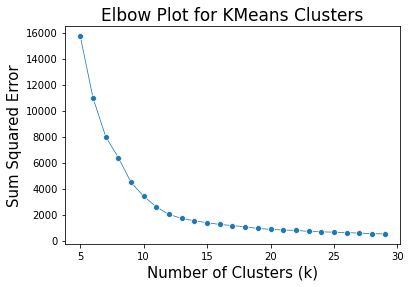

In [37]:
sum_squared_error = elbow_method(df_scaled_tpm)
plot_scores(scores=sum_squared_error, 
            x_min = 5, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Sum Squared Error", 
            title = "Elbow Plot for KMeans Clusters")

### Sillhouette Coefficient Method

"quantifies how well a data point fits into its assigned cluster" ~ source above

they range from -1 to 1, and larger, the closer the samples are to their clusters than others. Thus, for a sillhoutte score, we need at least two clusters to compare from.

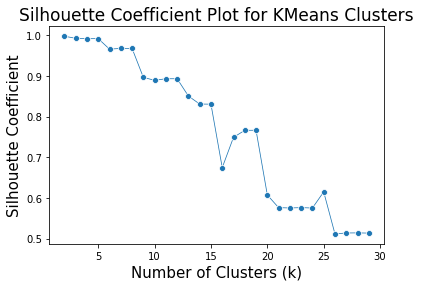

In [38]:
s_coefficients = silhouette_method(df_scaled_tpm)
plot_scores(scores=s_coefficients, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Silhouette Coefficient", 
            title = "Silhouette Coefficient Plot for KMeans Clusters")

### Calinski-Harabasz Method

ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (higher score is better - well defined clusters)

--> "also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters" ~ scikit-learn documentation

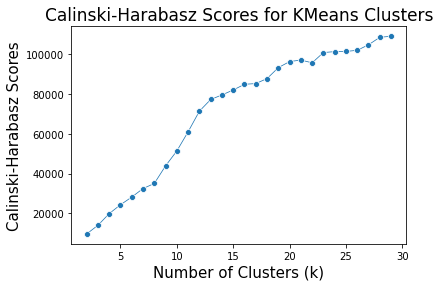

In [39]:
ch_scores = ch_method(df_scaled_tpm)
plot_scores(scores=ch_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Calinski-Harabasz Scores", 
            title = "Calinski-Harabasz Scores for KMeans Clusters")

### Davies-Bouldin Method

average similarity between clusters (lower score is better - indicates better separation b/w clusters)

- "compares the distance between clusters with the size of the clusters themselves." ~ scikit-learn

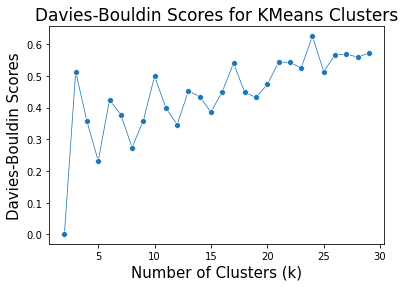

In [40]:
db_scores = db_method(df_scaled_tpm)
plot_scores(scores=db_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Davies-Bouldin Scores", 
            title = "Davies-Bouldin Scores for KMeans Clusters")

### Dunn's Index Method

"Dunn’s Index captures the same idea as the DB Index. Dunn’s Index is equal to the minimum inter-cluster distance divided by the maximum cluster size. A higher DI implies better clustering"

- Perhaps this is similar to the insights we may get from CH Method above

### Further Musings: 

- Paper: https://link.springer.com/article/10.1007/s10791-008-9066-8
- Article: https://medium.datadriveninvestor.com/evaluation-metrics-for-clustering-96dcdbea437d

## Cluster Visualization + Analysis: 
- It is evident through the elbow method that __ is the optimal number of clusters

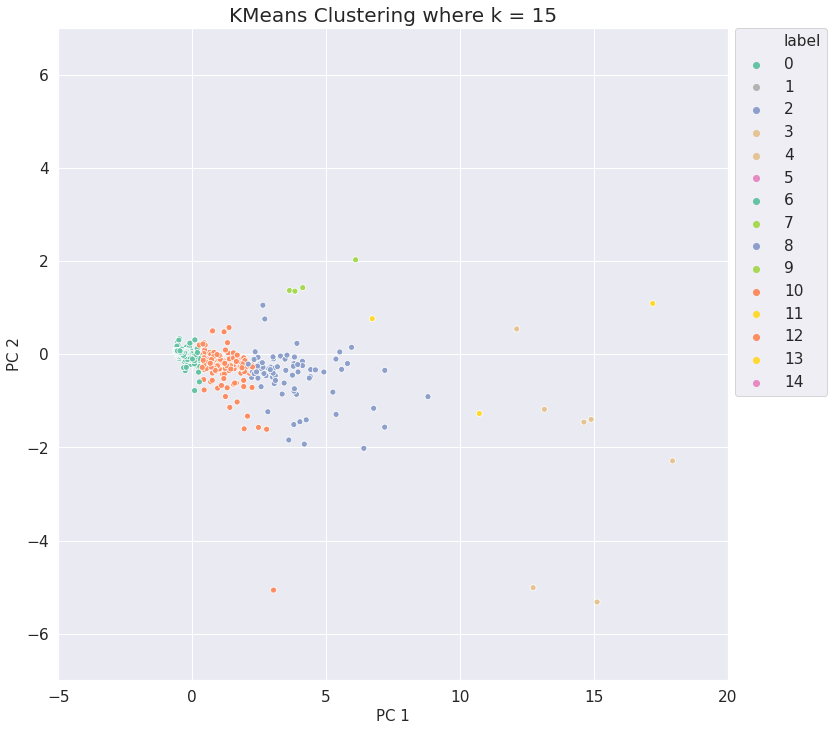

In [54]:
n_clusters = 15
xlim = [-5, 20]
ylim = [-7, 7]
labels = plot_kmeans(n_clusters, df_scaled_tpm, xlim, ylim)

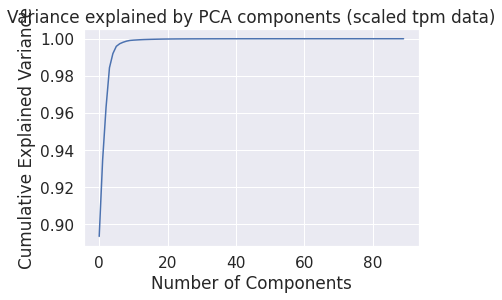

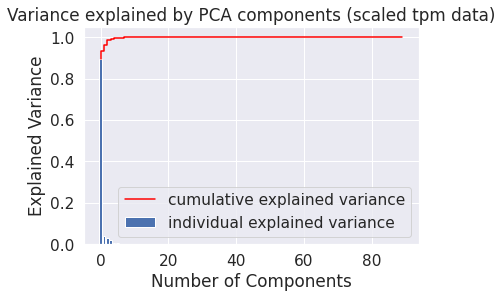

In [55]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(90)
pca_explained.fit_transform(df_scaled_tpm)
plot_pca_var(pca_explained, tag = "scaled tpm data")

### Cluster Composition Histogram

In [56]:
# COMPANION PLOT: Histogram of cluster composition
cluster_details = np.unique(labels, return_counts=True)
cluster_details

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
       dtype=int32),
 array([3926,    1,    1,    1,    7,    1,    1,    4,   84,    1,    2,
           1,  180,    2,    1]))

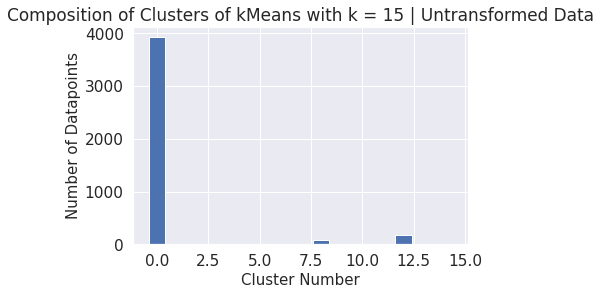

In [57]:
title_add = "kMeans with k = 15 | Untransformed Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

### Further musings in clustering + viz tools: 
- Paper: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-16-S11-S5

## Log Ratio Input - KMeans Clustering

### Log Ratio with respect to Average TPM values for loci under the ideal growth conditions (uMax)

In [137]:
np.log(2.983003 / 53.03588372288866)

-2.8780382246004312

In [135]:
df_raw_tpm

,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_FM_85_TR1_tpm,5GB1_FM_85_TR2_tpm,5GB1_FM_86_TR1_tpm,5GB1_FM_87_TR1_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
locus_tag,,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,2.983003,6.083848,48.914921,52.247450,25.801902,34.978170,28.372788,28.511759,28.529425,29.522757,...,24.799983,28.999182,45.869368,24.207536,38.607373,38.860668,39.930174,38.405431,30.297582,41.298441
EQU24_RS00010,1.657784,3.945284,51.365629,54.997425,37.266017,40.144206,27.437700,28.698564,26.548988,26.871965,...,47.224797,43.853272,31.703933,44.940393,52.602767,52.511746,45.515136,46.548139,37.202951,52.952410
EQU24_RS00015,1.465515,2.599771,33.956257,30.029783,21.766802,27.921558,16.620863,15.612811,16.639291,17.008650,...,9.199880,14.824317,20.286628,10.805231,31.400991,34.964128,22.708157,22.803325,19.457103,29.884124
EQU24_RS00020,3.250081,4.351580,64.634281,72.767824,53.082824,55.645529,36.845081,36.451903,37.563079,35.883478,...,58.525599,53.267719,36.837108,72.972943,74.898501,80.900761,69.169079,65.693179,57.640223,68.356759
EQU24_RS00025,1.572728,3.847084,74.851354,62.759260,46.398014,58.042363,27.482559,30.430176,26.902591,26.517246,...,29.908596,36.386110,36.281087,34.612485,50.374948,49.399547,39.042158,35.920964,41.512392,40.277192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,2.350157,3.267944,104.538835,103.914151,78.314069,59.735923,58.883576,57.273346,66.432013,69.246352,...,25.912525,34.318735,49.582913,22.908882,70.968047,92.094879,22.151468,19.803259,20.077390,24.558375
EQU24_RS22140,5.311582,12.576353,379.736212,401.792811,208.144267,210.870167,204.810175,204.809505,211.332600,218.607992,...,182.054412,181.626715,156.193274,188.503252,328.839579,403.059110,96.219044,93.577806,89.830995,130.901229
EQU24_RS22145,9.439775,21.122962,500.179230,495.312554,260.061454,331.405028,300.816500,309.198602,312.687538,317.653906,...,125.085490,182.871145,183.918377,179.119605,301.253428,329.953989,47.691158,60.717488,55.789018,66.465222


In [134]:
umax_averages

{'EQU24_RS00005': 53.03588372288866,
 'EQU24_RS00010': 60.981256801407596,
 'EQU24_RS00015': 34.93307585592701,
 'EQU24_RS00020': 72.0424894545747,
 'EQU24_RS00025': 49.63808536250938,
 'EQU24_RS00030': 32.4474958527435,
 'EQU24_RS00035': 86.9580633877638,
 'EQU24_RS00040': 22.537664963014564,
 'EQU24_RS00045': 19.038460046255008,
 'EQU24_RS00050': 18.692985905039226,
 'EQU24_RS00055': 14.745832067252616,
 'EQU24_RS00060': 28.203395089334716,
 'EQU24_RS00065': 12.849787933225747,
 'EQU24_RS00070': 8.153624062770692,
 'EQU24_RS00075': 6.521781936836054,
 'EQU24_RS00080': 13.780711082045427,
 'EQU24_RS00085': 70.51979329226658,
 'EQU24_RS00090': 92.60334412326914,
 'EQU24_RS00095': 123.23037346441099,
 'EQU24_RS00100': 106.1903014014923,
 'EQU24_RS00105': 184.0957231632798,
 'EQU24_RS00110': 334.19908235194845,
 'EQU24_RS00115': 399.91214641937876,
 'EQU24_RS00125': 60.61183976432408,
 'EQU24_RS00130': 12.808039330177927,
 'EQU24_RS00135': 18.136952425185928,
 'EQU24_RS00140': 9.62951119

In [29]:
# Log Ratio Data --> 

# list of all samples
samples = list(sample2condition.keys())

df_T = df.set_index('locus_tag')[samples].T.reset_index().rename(columns={'index':'sample'})

# your code here (add exp_condition column)
df_T['exp_condition'] = df_T['sample'].apply(lambda x: sample2condition.get(x))

df_Avg = df_T.groupby(['exp_condition']).mean()

umax_averages = df_Avg.T.uMax.apply(lambda x: x + 1).to_dict()

df_raw_tpm = np.add(df_raw_tpm, 0.05)

df_log_ratio = np.log(df_raw_tpm.T / list(umax_averages.values())).T

df_log_ratio.set_axis(umax_averages.keys())


,5GB1_ferm_Ack_QC_tpm,5GB1_ferm_WT_QC_tpm,5GB1_FM03_TR1_QC_tpm,5GB1_FM03_TR2_QC_tpm,5GB1_FM11_TR1_QC_tpm,5GB1_FM11_TR2_QC_tpm,5GB1_FM12_TR1_tpm,5GB1_FM12_TR1_QC_tpm,5GB1_FM12_TR2_tpm,5GB1_FM12_TR2_QC_tpm,...,5GB1_FM_85_TR1_tpm,5GB1_FM_85_TR2_tpm,5GB1_FM_86_TR1_tpm,5GB1_FM_87_TR1_tpm,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
EQU24_RS00005,-2.878038,-2.165331,-0.080886,-0.014978,-0.720521,-0.416245,-0.625538,-0.620652,-0.620033,-0.585807,...,-0.760126,-0.603701,-0.145171,-0.784305,-0.317525,-0.310986,-0.283836,-0.322770,-0.559901,-0.250144
EQU24_RS00010,-3.605085,-2.738046,-0.171597,-0.103280,-0.492485,-0.418088,-0.798649,-0.753719,-0.831575,-0.819483,...,-0.255647,-0.329717,-0.654126,-0.305230,-0.147798,-0.149530,-0.292522,-0.270080,-0.494178,-0.141173
EQU24_RS00015,-3.171227,-2.598011,-0.028361,-0.151244,-0.473048,-0.224035,-0.742775,-0.805342,-0.741667,-0.719712,...,-1.334244,-0.857165,-0.543472,-1.173404,-0.106595,0.000889,-0.430710,-0.426528,-0.585222,-0.156107
EQU24_RS00020,-3.098576,-2.806717,-0.108511,0.010018,-0.305403,-0.258254,-0.670534,-0.681262,-0.651234,-0.696979,...,-0.207792,-0.301926,-0.670750,0.012833,0.038878,0.115967,-0.040702,-0.092261,-0.223035,-0.052516
EQU24_RS00025,-3.451947,-2.557443,0.410746,0.234548,-0.067502,0.156415,-0.591207,-0.489324,-0.612536,-0.626963,...,-0.506612,-0.310571,-0.313462,-0.360544,0.014736,-0.004817,-0.240116,-0.323437,-0.178766,-0.208973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-3.655989,-3.326310,0.139088,0.133094,-0.149744,-0.420537,-0.434909,-0.462635,-0.314292,-0.272800,...,-1.255744,-0.974779,-0.606825,-1.378946,-0.248241,0.012348,-1.412567,-1.524624,-1.510877,-1.309418
EQU24_RS22140,-4.399034,-3.537106,-0.129447,-0.072988,-0.730693,-0.717681,-0.746840,-0.746844,-0.715491,-0.681644,...,-0.864618,-0.866970,-1.017830,-0.829809,-0.273354,-0.069841,-1.502297,-1.530131,-1.570994,-1.194481
EQU24_RS22145,-3.866393,-3.060964,0.103641,0.093864,-0.550407,-0.307984,-0.404825,-0.377341,-0.366121,-0.350363,...,-1.282328,-0.902543,-0.896833,-0.923271,-0.403373,-0.312372,-2.246579,-2.005093,-2.089748,-1.914646
EQU24_RS22150,-4.094819,-3.427586,-0.089411,-0.055405,-0.670227,-0.415197,-0.453014,-0.464075,-0.474722,-0.444352,...,-1.442261,-1.073516,-1.164732,-1.179417,-0.861653,-0.651201,-2.268346,-2.095365,-2.012000,-2.071553


In [30]:
np.max(df_log_ratio)

5GB1_ferm_Ack_QC_tpm     2.086172
5GB1_ferm_WT_QC_tpm      2.038011
5GB1_FM03_TR1_QC_tpm     1.288191
5GB1_FM03_TR2_QC_tpm     1.183177
5GB1_FM11_TR1_QC_tpm     4.036033
                           ...   
5GB1_pA9_yellow_tpm      3.092210
5GB1C-JG15-La-BR1_tpm    5.837910
5GB1C-JG15-La-BR2_tpm    5.616879
5GB1C-JG15-N-BR1_tpm     5.009977
5GB1C-JG15-N-BR2_tpm     4.027901
Length: 90, dtype: float64

## Log Ratio - Finding number of clusters 
***

### Elbow Method

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


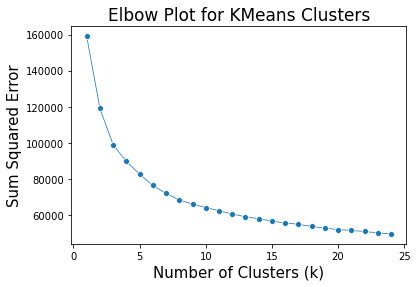

In [31]:
sum_squared_error = elbow_method(df_log_ratio, x_min= 1, x_max=25)
plot_scores(scores=sum_squared_error, 
            x_min = 1, 
            x_max = 25, 
            x_label = "Number of Clusters (k)", 
            y_label = "Sum Squared Error", 
            title = "Elbow Plot for KMeans Clusters")

### Sillhouette Coefficient Method

"quantifies how well a data point fits into its assigned cluster" ~ source above

they range from -1 to 1, and larger, the closer the samples are to their clusters than others. Thus, for a sillhoutte score, we need at least two clusters to compare from.

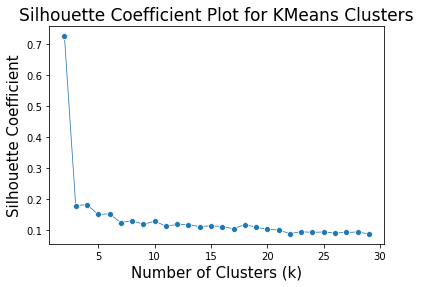

In [269]:
s_coefficients = silhouette_method(df_log_ratio)
plot_scores(scores=s_coefficients, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Silhouette Coefficient", 
            title = "Silhouette Coefficient Plot for KMeans Clusters")

### Calinski-Harabasz Method

ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (higher score is better - well defined clusters)

--> "also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters" ~ scikit-learn documentation

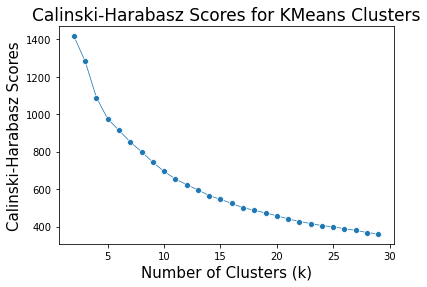

In [270]:
ch_scores = ch_method(df_log_ratio)
plot_scores(scores=ch_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Calinski-Harabasz Scores", 
            title = "Calinski-Harabasz Scores for KMeans Clusters")

### Davies-Bouldin Method

average similarity between clusters (lower score is better - indicates better separation b/w clusters)

- "compares the distance between clusters with the size of the clusters themselves." ~ scikit-learn

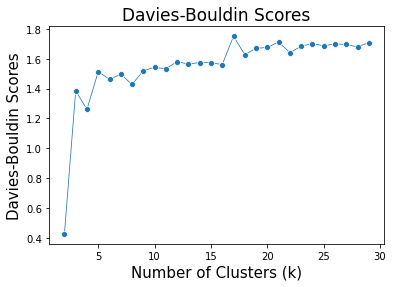

In [271]:
db_scores = db_method(df_log_ratio)
plot_scores(scores=db_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Davies-Bouldin Scores", 
            title = "Davies-Bouldin Scores")




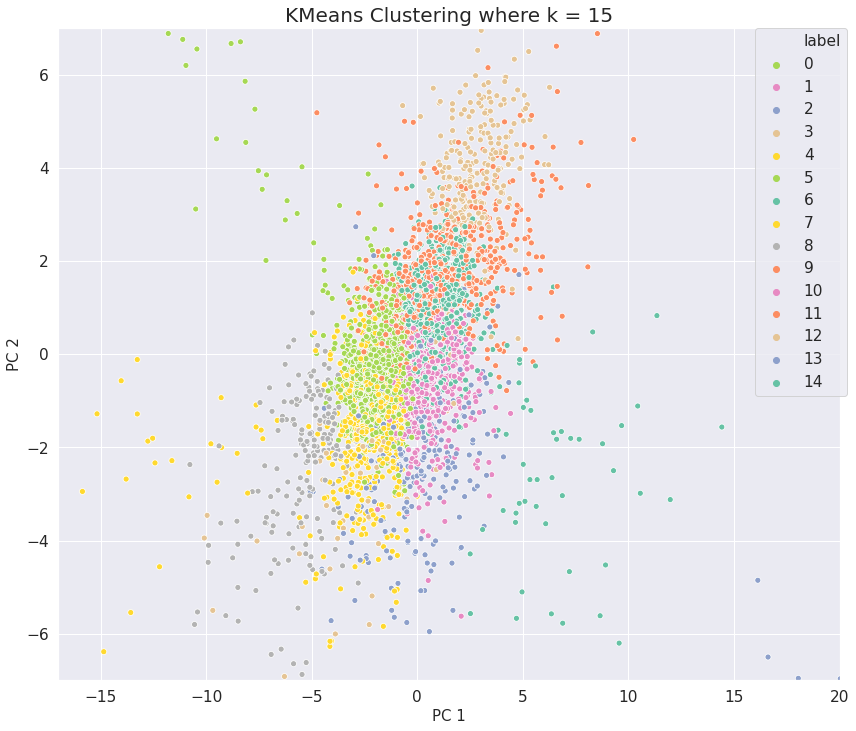

In [58]:
n_clusters = 15
xlim = [-17, 20]
ylim = [-7, 7]
figsize = (14, 12)
labels = plot_kmeans(n_clusters, df_log_ratio, xlim, ylim, figsize)

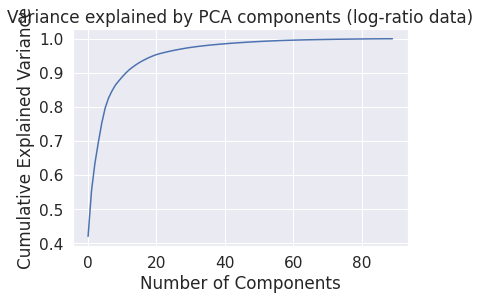

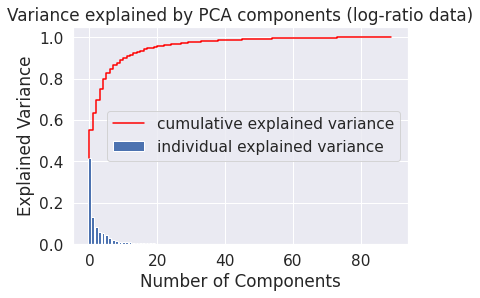

In [59]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(90)
pca_explained.fit_transform(df_log_ratio)
plot_pca_var(pca_explained, tag = "log-ratio data")

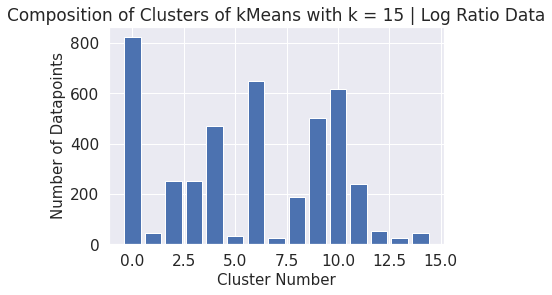

In [61]:
# COMPANION PLOT: Histogram of cluster composition
cluster_details = np.unique(labels, return_counts=True)
title_add = "kMeans with k = 15 | Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

## DBSCAN Clustering Methods

In [43]:
from sklearn.cluster import DBSCAN

In [46]:
# GRID SEARCH CV --> seemed fun to implement, so tried by hand 

hyper_params = []

for min_sample in range(2, 6):
    for e_val in np.arange(1, 3, 0.50):
        
        dbscan = DBSCAN(eps= e_val, min_samples= min_sample)
        search_gene_clusters_dbscan = dbscan.fit(df_log_ratio)
        
        search_labels_dbscan = search_gene_clusters_dbscan.labels_
        num_clusters = len(set(search_labels_dbscan))
        
        if num_clusters > 5:
            hyper_params.append([e_val, min_sample, num_clusters])

np.set_printoptions(threshold=np.inf)
print(hyper_params)


KeyboardInterrupt: 

In [ ]:
# Sort and order the resulting hyper paramters
hyper_params.sort(key=lambda x: x[2], reverse= True)
hyper_params

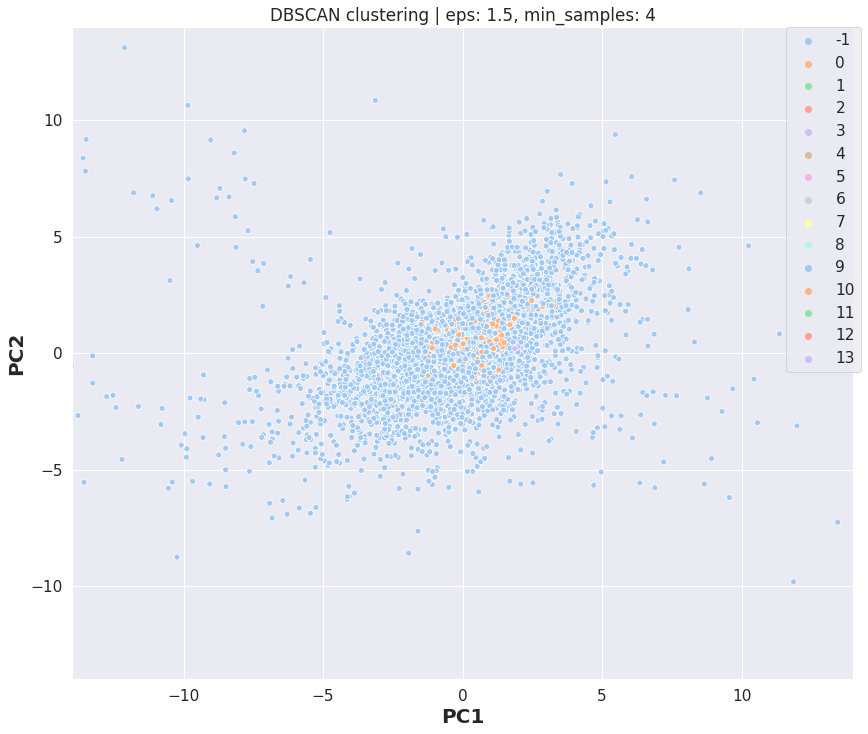

In [67]:
eps = 1.5
min_samples = 4
xlim = [-14, 14]
ylim = [-14, 14]
figsize = (14,12)
labels_dbscan = plot_dbscan(eps, min_samples, df_log_ratio, xlim, ylim, figsize)

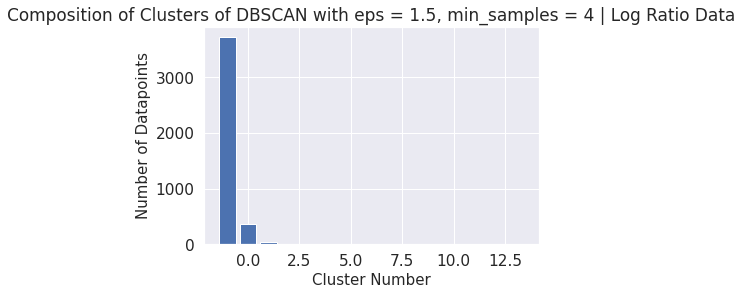

In [68]:
# COMPANION PLOT: Histogram of cluster composition
cluster_details = np.unique(labels_dbscan, return_counts=True)
title_add = "DBSCAN with eps = " + str(eps) + ", min_samples = " + str(min_samples)+ " | Log Ratio Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

# Averaged Data

In [70]:
# kmeans --> how many k clusters do we wish to discover? elbow or sillhouette methods


kmeans = KMeans(
            init = "k-means++",  # Notice: when init is no longer random, inertia lower
            n_clusters = 15,
            n_init = 10, 
            max_iter = 300, 
            random_state=42)

fitted = kmeans.fit(df_avg_scaled_tpm)

#inertia is quite high --> not the ideal set of clusters here
fitted.inertia_


21640.792573141323

## Finding number of clusters 
***

### Elbow Method

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


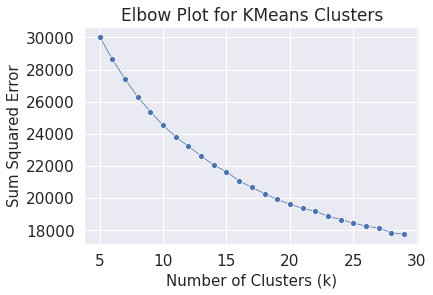

In [71]:
sum_squared_error = elbow_method(df_avg_scaled_tpm)
plot_scores(scores=sum_squared_error, 
            x_min = 5, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Sum Squared Error", 
            title = "Elbow Plot for KMeans Clusters")

### Sillhouette Coefficient Method

"quantifies how well a data point fits into its assigned cluster" ~ source above

they range from -1 to 1, and larger, the closer the samples are to their clusters than others. Thus, for a sillhoutte score, we need at least two clusters to compare from.

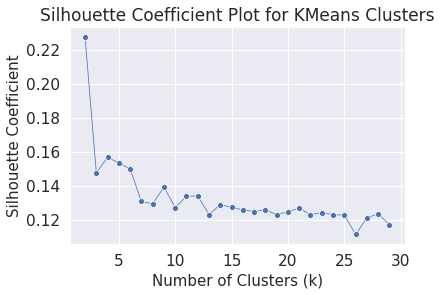

In [72]:
s_coefficients = silhouette_method(df_avg_scaled_tpm)
plot_scores(scores=s_coefficients, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Silhouette Coefficient", 
            title = "Silhouette Coefficient Plot for KMeans Clusters")

### Calinski-Harabasz Method

ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters (higher score is better - well defined clusters)

--> "also known as the Variance Ratio Criterion - can be used to evaluate the model, where a higher Calinski-Harabasz score relates to a model with better defined clusters" ~ scikit-learn documentation

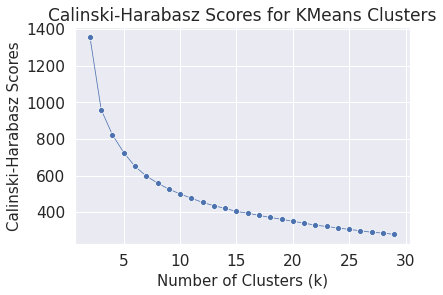

In [73]:
ch_scores = ch_method(df_avg_scaled_tpm)
plot_scores(scores=ch_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Calinski-Harabasz Scores", 
            title = "Calinski-Harabasz Scores for KMeans Clusters")

### Davies-Bouldin Method

average similarity between clusters (lower score is better - indicates better separation b/w clusters)

- "compares the distance between clusters with the size of the clusters themselves." ~ scikit-learn

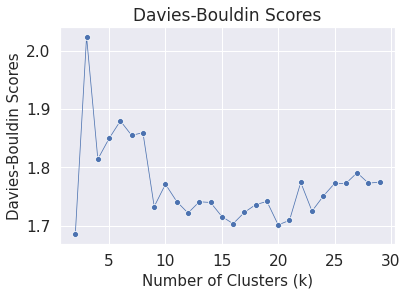

In [75]:
db_scores = db_method(df_avg_scaled_tpm)
plot_scores(scores=db_scores, 
            x_min = 2, 
            x_max = 30, 
            x_label = "Number of Clusters (k)", 
            y_label = "Davies-Bouldin Scores", 
            title = "Davies-Bouldin Scores")

### Dunn's Index Method

"Dunn’s Index captures the same idea as the DB Index. Dunn’s Index is equal to the minimum inter-cluster distance divided by the maximum cluster size. A higher DI implies better clustering"

- Perhaps this is similar to the insights we may get from CH Method above

### Further Musings: 

- Paper: https://link.springer.com/article/10.1007/s10791-008-9066-8
- Article: https://medium.datadriveninvestor.com/evaluation-metrics-for-clustering-96dcdbea437d

## k-Means Clustering

In [138]:
df_avg_scaled_tpm

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_low_iron_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,-0.909002,-1.113499,-0.339628,0.752159,-0.215905,-0.077910,-0.036742,-0.800440,0.250164,1.064007,2.566352,-0.448025,0.630081,0.083214,-0.490574,-1.831540,0.802957,0.046266,1.435479,-1.367412
EQU24_RS00010,0.375879,-1.578377,-0.264732,0.583348,-0.262975,-0.550101,-0.363730,-0.166914,0.205724,1.617663,2.673926,-0.802287,0.667229,-0.243435,-0.529768,-1.370163,0.869095,0.017351,0.602563,-1.480295
EQU24_RS00015,-1.277528,-0.537212,-0.214131,0.557094,-0.011092,-0.865899,-0.292966,-1.259905,1.100505,1.144154,2.406532,-0.533059,0.619531,0.508193,0.170814,-1.469626,0.685363,-0.692150,1.189759,-1.228376
EQU24_RS00020,1.214163,-2.289077,0.340324,0.014674,0.043282,-0.102053,0.033310,-0.042794,1.272088,1.001425,1.340101,-0.813271,0.298830,-0.517893,-0.134374,-1.953208,0.527100,0.513216,0.865298,-1.611141
EQU24_RS00025,0.177218,-1.840263,0.021877,0.636042,0.073254,-0.450969,-0.537466,-0.624154,0.636633,0.547380,2.745112,-0.734405,0.720953,-0.879293,0.812341,-1.757539,0.552483,0.249991,0.546316,-0.895512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,-0.224448,-0.941750,-0.674489,0.576261,-1.223329,-0.631435,-1.252614,-0.885554,1.245795,1.586486,0.024662,0.371401,0.634446,0.887685,0.727363,-1.476565,1.375760,-0.882123,1.597450,-0.835001
EQU24_RS22140,1.186216,-1.284894,-0.475628,0.231579,-1.131657,-0.539019,-1.242391,-0.449047,1.296014,1.078694,-0.085112,-0.021489,0.610629,1.230015,-0.186811,-1.506645,1.050734,-0.585724,1.915108,-1.090569
EQU24_RS22145,-0.684908,-0.648104,-0.625461,0.342034,-1.483142,-0.471344,-1.431407,-0.715348,0.716616,1.345035,0.083810,0.552406,0.700475,1.399826,0.540569,-1.335084,1.262869,-0.438083,1.907212,-1.017969


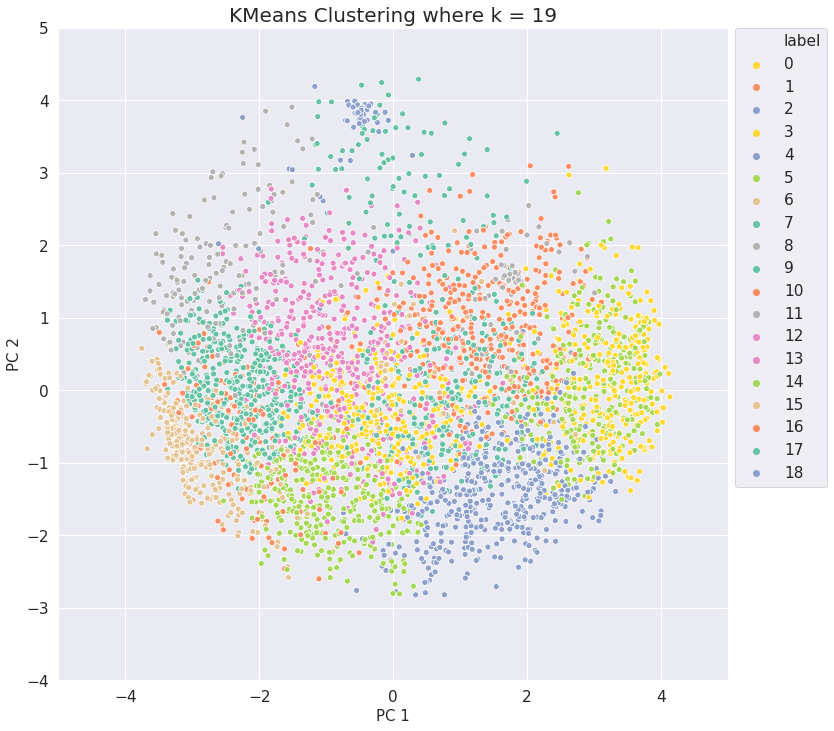

In [142]:
# Plotting our clusters!
avg_n_clusters = 19
xlim = [-5, 5]
ylim = [-4, 5]
figsize = (14, 12)
labels = plot_kmeans(avg_n_clusters, df_avg_scaled_tpm, xlim, ylim)


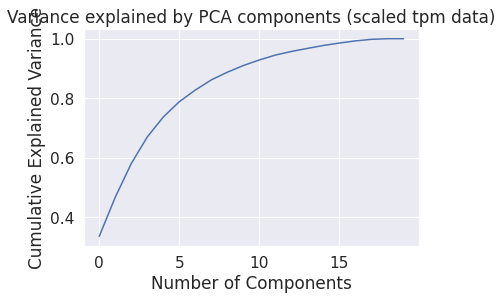

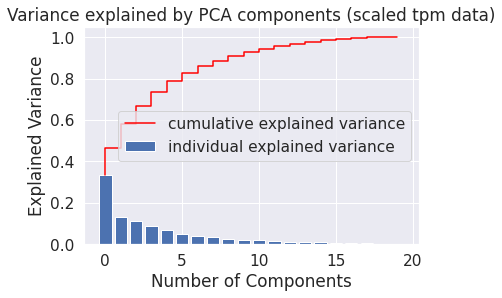

In [77]:
# draw basic matplotlib plots of variance explained and projections
pca_explained = PCA(20)
pca_explained.fit_transform(df_avg_scaled_tpm)
plot_pca_var(pca_explained, tag = "scaled tpm data")

### Cluster Composition Histogram

In [78]:
# COMPANION PLOT: Histogram of cluster composition
cluster_details = np.unique(labels, return_counts=True)
cluster_details

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18], dtype=int32),
 array([300, 146,  65, 307, 160, 348, 307, 424,  79, 275, 269, 181, 304,
        197, 295,  54, 109,  96, 297]))

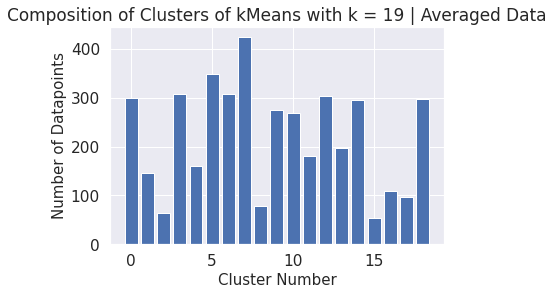

In [81]:
title_add = "kMeans with k = " + str(avg_n_clusters) + " | Averaged Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

## DBSCAN Clustering

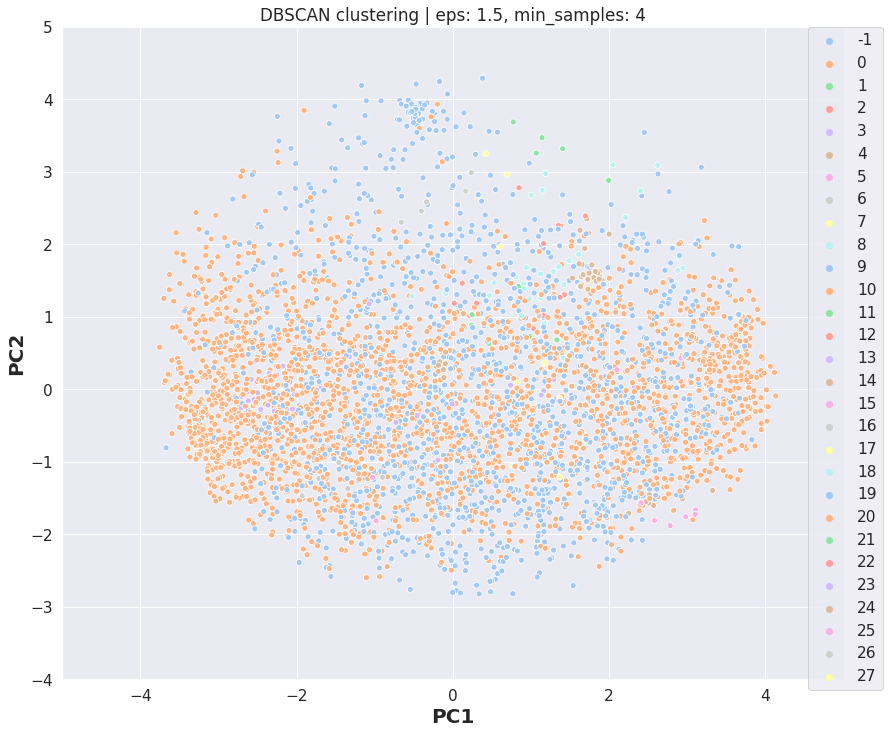

In [101]:
# DBSCAN 

eps = 1.5
min_samples = 4
xlim = [-5, 5]
ylim = [-4, 5]
figsize = (14,12)
labels_dbscan = plot_dbscan(eps, min_samples, df_avg_scaled_tpm, xlim, ylim, figsize)



In [102]:
# COMPANION PLOT: Histogram of cluster composition
cluster_details = np.unique(labels_dbscan, return_counts=True)
cluster_details

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
        16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 array([1508, 2407,   16,   14,   13,   38,    7,    7,    4,   30,    9,
           7,    5,    4,   31,   11,    4,    4,    3,    4,   52,    4,
           5,    5,    3,    8,    3,    5,    2]))

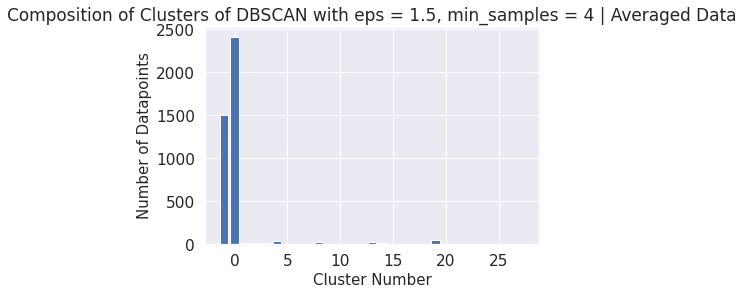

In [104]:
title_add = "DBSCAN with eps = " + str(eps) + ", min_samples = " + str(min_samples) + " | Averaged Data"
clusterCompositionPlot(cluster_details[0], cluster_details[1], title_add)

# Analysis of Cluster Metrics

### Mock Graph Goal

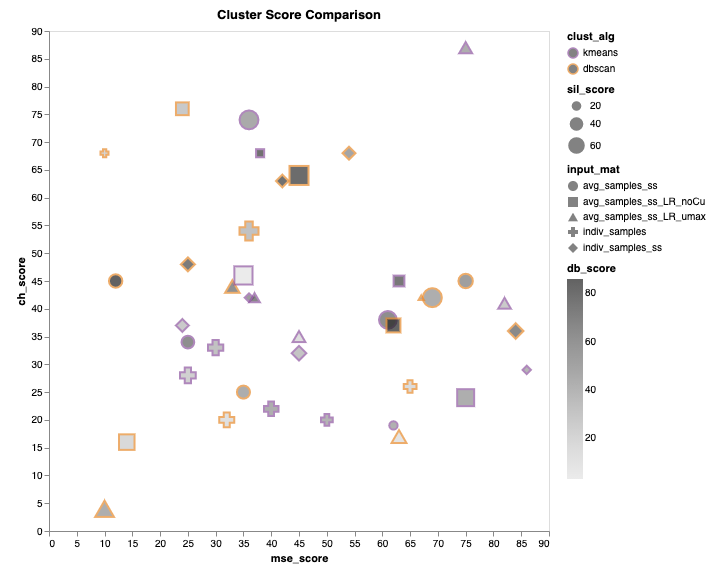

In [111]:
# Pipeline for metric collection - TOY EXAMPLE

metrics_test = []
d1 = {"input": "raw scaled", "clustering": "kMeans", "sil_score": 40, "sse_score": 40, "ch_score": 40, "db_score": 40, "n_clusters": 15}
d2 = {"input": "log ratio", "clustering": "DBSCAN", "sil_score": 40, "sse_score": 40, "ch_score": 40, "db_score": 40, "eps": 1, "min_samples": 4}

metrics_test.append(d1)
metrics_test.append(d2)

df_test = pd.DataFrame(metrics_test)
df_test


,input,clustering,sil_score,sse_score,ch_score,db_score,n_clusters,eps,min_samples
0,raw scaled,kMeans,40,40,40,40,15.0,NaN,NaN
1,log ratio,DBSCAN,40,40,40,40,NaN,1.0,4.0


In [130]:
# Collect metrics for kMeans

kMeans_metrics = []

# range of clusters to observe
x_min= 2
x_max= 30

input_dataframes = [df_scaled_tpm, df_log_ratio, df_avg_scaled_tpm]
input_string_form = ["raw scaled","log ratio", "average scaled"]

# Uses each of the above inputs for transformed data
for input_num, data in enumerate(input_dataframes):
    
    # Generates scores for each method
    s_coefficients = silhouette_method(data, x_min, x_max)
    sum_squared_error = elbow_method(data, x_min, x_max)
    ch_scores = ch_method(data, x_min, x_max)
    db_scores = db_method(data, x_min, x_max)
    
    # Cycles through the parameter search space for kmeans
    for n_clusters in range(x_min, x_max):
        
        # score index adjusted for length of score lists + cluster number
        list_index = n_clusters - 2
        
        # Add dictionary entity for each into a metric collection list
        cur_run_metrics = {"input": input_string_form[input_num], 
                           "clustering": "kMeans", 
                           "sil_score": s_coefficients[list_index], 
                           "sse_score": sum_squared_error[list_index],  
                           "ch_score": ch_scores[list_index], 
                           "db_score": db_scores[list_index], 
                           "n_clusters": n_clusters}
        
        kMeans_metrics.append(cur_run_metrics)
    
    # Cycles through the parameter search space for DBSCAN
    
#     for min_sample in range(2, 6):
        
#         for e_val in np.arange(1, 3, 0.50):
#             dbscan = DBSCAN(eps= e_val, min_samples= min_sample)
#             search_gene_clusters_dbscan = dbscan.fit(df_log_ratio)

#             search_labels_dbscan = search_gene_clusters_dbscan.labels_
#             num_clusters = len(set(search_labels_dbscan))
        
#         # score index adjusted for length of score lists + cluster number
#         list_index = n_clusters - 2
        
#         # Add dictionary entity for each into a metric collection list
#         cur_run_metrics = {"input": input_string_form[input_num], 
#                            "clustering": "kMeans", 
#                            "sil_score": s_coefficients[list_index], 
#                            "sse_score": sum_squared_error[list_index],  
#                            "ch_score": ch_scores[list_index], 
#                            "db_score": db_scores[list_index], 
#                            "n_clusters": n_clusters}
        
#         kMeans_metrics.append(cur_run_metrics)

df_kmeans_metrics = pd.DataFrame(kMeans_metrics)
df_kmeans_metrics

,input,clustering,sil_score,sse_score,ch_score,db_score,n_clusters
0,raw scaled,kMeans,0.997612,115296.766879,9637.479131,0.001544,2
1,raw scaled,kMeans,0.992588,49628.426308,13977.574230,0.513045,3
2,raw scaled,kMeans,0.991641,25012.653245,19865.255902,0.356361,4
3,raw scaled,kMeans,0.991758,15721.240194,24320.479212,0.231560,5
4,raw scaled,kMeans,0.965911,10985.609652,28199.649893,0.423952,6
...,...,...,...,...,...,...,...
79,average scaled,kMeans,0.122683,18447.948838,305.695681,1.772375,25
80,average scaled,kMeans,0.111279,18263.095989,298.062628,1.772333,26
81,average scaled,kMeans,0.120921,18130.577310,289.801286,1.790804,27
82,average scaled,kMeans,0.123490,17853.529187,285.735998,1.772882,28


In [132]:
domain = ['kMeans']
range_ = ['#984EA3', '#F58517']

chart = alt.Chart(df_kmeans_metrics, 
                  title=f"Cluster Score Comparison",
                  height=500,
                  width=500
).mark_point(strokeOpacity=1.0).encode(
    x='sse_score:Q',
    y='db_score:Q',
    size='ch_score:Q',
    fill=alt.Color('sil_score:Q',
                    scale=alt.Scale(scheme="greys"),
                    ),
    color=alt.Color('clustering:N',
                    scale=alt.Scale(domain=domain, range=range_),
                    ),
    shape='input:N',
    tooltip=['input:N','clustering:N','n_clusters:N'],

).interactive().configure_axis(
    grid=False
)

chart

alt.Chart(...)

28

## PRACTICE

In [ ]:
# Core points: 

core_genes_dbscan= np.zeros_like(labels_dbscan, dtype=bool)
core_genes_dbscan[dbscan.core_sample_indices_] = True
core_genes_dbscan

In [ ]:
dbscan.core_sample_indices_

In [ ]:
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_clusters_dbscan

In [ ]:
# Black removed and is used for noise instead.
unique_labels = set(labels_dbscan)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]